In [1]:
from mylib.statistic_test import *

code_id = '0351 - Cross-Model Prediction'
loc = os.path.join(figpath, code_id)
mkdir(loc)

model_dir = os.path.join(figpath, "0346 - GLM for all sessions")
mkdir(join(loc, 'Res'))

from mylib.model.glms import GLM as GenearlizedLinearModel
from mylib.model import EqualRateDriftModel, TwoProbDriftModel
from mylib.model import TwoProbabilityIndependentModel
from mylib.model import JointProbabilityModel
from mylib.model import HMM
from mylib.model import ContinuousHiddenStateModel
from mylib.model import ProbabilityRNN, IntegrativeRNN

from mylib.field.tracker_v2 import Tracker2d

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\0351 - Cross-Model Prediction is already existed!
        D:\Data\FinalResults\0351 - Cross-Model Prediction\Res is already existed!
Using device: cpu
Using device: cpu
Using device: cpu


In [2]:
def fit_models(
    field_reg, 
    GLM: np.ndarray, 
    qualified_idx: np.ndarray, 
    file_name: str,  
    model_dir: str,
    
    is_gate: bool = True
):
    with open(model_dir, 'rb') as f:
        Models, M2s = pickle.load(f)

    M1: EqualRateDriftModel = Models[0]
    M12: TwoProbDriftModel = Models[1]
    M2: TwoProbabilityIndependentModel = Models[2]
    M3: JointProbabilityModel = Models[3]
    M41: HMM = Models[4]
    M42: HMM = Models[5]
    M43: HMM = Models[6]
    M44: HMM = Models[7]
    M51: ContinuousHiddenStateModel = Models[8]
    M52: ContinuousHiddenStateModel = Models[9]
    M53: ContinuousHiddenStateModel = Models[10]
    M54: ContinuousHiddenStateModel = Models[11]
    M61: ProbabilityRNN = Models[12]
    M62: ProbabilityRNN = Models[13]
    M63: ProbabilityRNN = Models[14]
    
    G_all: GenearlizedLinearModel = M2s[0]
    G01: GenearlizedLinearModel = M2s[1]
    G02: GenearlizedLinearModel = M2s[2]
    G03: GenearlizedLinearModel = M2s[3]
    G04: GenearlizedLinearModel = M2s[4]
    G05: GenearlizedLinearModel = M2s[5]
    G06: GenearlizedLinearModel = M2s[6]
    G07: GenearlizedLinearModel = M2s[7]
    G08: GenearlizedLinearModel = M2s[8]
    G09: GenearlizedLinearModel = M2s[9]
    G2: GenearlizedLinearModel = M2s[10]
    G3: GenearlizedLinearModel = M2s[11]

    res = {
        "Step": [],
        "Loss": [],
        "Model Type": []
    }
    
    # Preprocess Data ==========================================================
    for j in range(GLM.shape[2]):
        mean, std = np.nanmean(GLM[:, :, j]), np.nanstd(GLM[:, :, j])
        GLM[:, :, j] = (GLM[:, :, j] - mean) / std

    GLMC = cp.deepcopy(GLM)    
    GLM = GLM[:, :, [0, 1, 2, 4, 5, 6, 7, 8, 9]]
    print(f"Orignial shape: {field_reg.shape}, qualified shape: {qualified_idx.shape[0]}")
    
    #field_reg = field_reg[:, qualified_idx]
    tracker = Tracker2d(field_reg=field_reg)
    sequences = tracker.convert_to_sequence(is_gate=is_gate)
    lengths = np.array([len(seq) for seq in sequences])
    
    max_length = field_reg.shape[0]
    if max_length > 10:
        sequences, glm_params = tracker.convert_for_glm(field_reg, GLM, least_length=10, is_seq_format=True, is_gate=is_gate)
    else:
        sequences, glm_params = tracker.convert_for_glm(field_reg, GLM, least_length=5, is_seq_format=True, is_gate=is_gate)

    test_seq = sequences
    res['sequences'] = sequences
    
    def _update_res(
        res: dict, 
        model, 
        model_name: str
    ):
        model_loss = model.calc_loss_along_seq(test_seq)
        if model_loss.shape[0] < max_length - 1:
            model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
        res['Loss'].append(model_loss)
        res['Model Type'].append(np.repeat(model_name, max_length-1))
        res['Step'].append(np.arange(1, max_length))
        return res

    res = _update_res(res, M1, "Model I - 1")
    res = _update_res(res, M12, "Model I - 2")
    res = _update_res(res, M2, "Model II")
    res = _update_res(res, M3, "Model III")
    res = _update_res(res, M41, "Model IV - 5")
    res = _update_res(res, M42, "Model IV - 10")
    res = _update_res(res, M43, "Model IV - 20")
    res = _update_res(res, M44, "Model IV - 40")
    res = _update_res(res, M51, "Model V - linear")
    res = _update_res(res, M52, "Model V - logistic")
    res = _update_res(res, M53, "Model V - poly2")
    res = _update_res(res, M54, "Model V - poly3")
    res = _update_res(res, M61, "Model VI - 8")
    res = _update_res(res, M62, "Model VI - 16")
    res = _update_res(res, M63, "Model VI - 32")
    
    def _update_res_glm(
        res: dict, 
        model, 
        model_name: str,
        X: list[np.ndarray],
        Y: list[np.ndarray]
    ):
        model_loss = model.calc_loss_along_seq(X, Y)
        if model_loss.shape[0] < max_length - 1:
            model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
        res['Loss'].append(model_loss)
        res['Model Type'].append(np.repeat(model_name, max_length-1))
        res['Step'].append(np.arange(1, max_length))
        return res
    

    X = glm_params
    Y = test_seq
    res = _update_res_glm(res, G_all, "GLM All", X, Y)
    ModelNames2 = ['GLM All'] + [f'GLM RO {i}' for i in range(9)]

    for i, model in enumerate(M2s[1:10]):
        res = _update_res_glm(
            res, 
            model, 
            ModelNames2[i+1], 
            [x[:, i:i+1] for x in glm_params], 
            Y
        )

    if max_length > 10:
        sequences, glm_params = tracker.convert_for_glm(field_reg, GLMC, least_length=10, is_seq_format=True, is_gate=is_gate)
    else:
        sequences, glm_params = tracker.convert_for_glm(field_reg, GLMC, least_length=5, is_seq_format=True, is_gate=is_gate)
    
    resortidx = np.array([0, 1, 2, 4, 5, 6, 7, 8, 9, 3])
    X, Y = [para[:, resortidx] for para in glm_params], sequences
    res = _update_res_glm(res, G2, "GLM All + State", X, Y)
    
    predicted_prob = M53.get_predicted_prob(sequences)
    X = [
        np.hstack([
            glm_params[i][:, resortidx], 
            np.append(predicted_prob[i], 0)[:, np.newaxis]
        ]) for i in range(len(sequences))
    ]
    Y = [seq for seq in sequences]
    res = _update_res_glm(res, G3, "GLM All + Prob", X, Y)

    for k in ['Step', 'Loss', 'Model Type']:
        res[k] = np.concatenate(res[k])
        print(f"{k}: {res[k].shape}")

    with open(join(loc, 'Res', f"Res_{file_name}.pkl"), 'wb') as handle:
        pickle.dump(res, handle)

    return res

if exists(join(figdata, f"{code_id}.pkl")) == False:
    CrossModelLoss = {
        "Step": [],
        "Loss": [],
        "Model Type": [],
        "Train Paradigm": [],
        "Test Paradigm": [],
        "MiceID": []
    }
    
    paradms_list = ['MA', 'MB', 'MAf', 'MAb', 'HPf', 'HPb']
    
    for mouse in [10209, 10212, 10224, 10227, 10232, 10234]:
        paradms = paradms_list if mouse in [10209, 10212, 10224, 10227] else paradms_list[:2]
        print(f"Mouse {mouse}")
        for i, paradm_a in enumerate(paradms):
            for j, paradm_b in enumerate(paradms):
                if i != j:
                    print(f"  {paradm_b} -> {paradm_a}  ", end='')
                    if paradm_a in ['MA', 'MB']:
                        maze_type = 1 if paradm_a == 'MA' else 2
                        cellreg_i = np.where(
                            (f_CellReg_modi['maze_type'] == maze_type) & 
                            (f_CellReg_modi['MiceID'] == mouse) &
                            (f_CellReg_modi['paradigm'] == 'CrossMaze')
                        )[0]
                    elif paradm_a in ['MAf', 'MAb']:
                        cellreg_i = np.where(
                            (f_CellReg_modi['maze_type'] == 1) & 
                            (f_CellReg_modi['MiceID'] == mouse) &
                            (f_CellReg_modi['paradigm'] == 'ReverseMaze')
                        )[0]
                    elif paradm_a in ['HPf', 'HPb']:
                        cellreg_i = np.where(
                            (f_CellReg_modi['maze_type'] == 3) & 
                            (f_CellReg_modi['MiceID'] == mouse) &
                            (f_CellReg_modi['paradigm'] == 'HairpinMaze')
                        )[0]

                    with open(f_CellReg_modi['Trace File'][cellreg_i[0]], 'rb') as handle:
                        trace = pickle.load(handle)

                    if paradm_a in ['MA', 'MB']:
                        glmparams, is_qualified = trace['GLM']
                        field_reg = trace['field_reg']
                    elif paradm_a in ['MAf', 'HPf']:
                        glmparams, is_qualified = trace['GLM_cis']
                        field_reg = trace['cis']['field_reg']
                    elif paradm_a in ['MAb', 'HPb']:
                        glmparams, is_qualified = trace['GLM_trs']
                        field_reg = trace['trs']['field_reg']
                        
                    model_dirs = [
                        join(model_dir, f'{mouse}_{paradm_b}_iter{it}.pkl')
                        for it in range(10)
                    ]
                    losses = []
                    for n, mod_file in enumerate(model_dirs):
                        res = fit_models(
                            field_reg=field_reg,
                            GLM=glmparams,
                            qualified_idx=is_qualified,
                            file_name=f"{mouse}_Train_{paradm_b}_Test_{paradm_a}_iter{n}",
                            model_dir=mod_file
                        )
                        losses.append(res['Loss'])
                    
                    losses = np.vstack(losses)
                    losses = np.mean(losses, axis=0)

                    CrossModelLoss['Step'].append(res['Step'])
                    CrossModelLoss['Loss'].append(losses)
                    CrossModelLoss['Model Type'].append(res['Model Type'])
                    CrossModelLoss['Train Paradigm'].append(np.repeat(paradm_a, len(res['Step'])))
                    CrossModelLoss['Test Paradigm'].append(np.repeat(paradm_b, len(res['Step'])))
                    CrossModelLoss['MiceID'].append(np.repeat(mouse, len(res['Step'])))
                    print("Done.")
                    
    for k in CrossModelLoss.keys():
        CrossModelLoss[k] = np.concatenate(CrossModelLoss[k])

    with open(join(figdata, f"{code_id}.pkl"), 'wb') as handle:
        pickle.dump(CrossModelLoss, handle)

    CrossModelLossD = pd.DataFrame(CrossModelLoss)
    CrossModelLossD.to_excel(join(figdata, f"{code_id}.xlsx"), index=False)
    print(len(CrossModelLoss))
else:
    with open(join(figdata, f"{code_id}.pkl"), 'rb') as handle:
        CrossModelLoss = pickle.load(handle)


In [3]:
if exists(join(figdata, f" {code_id} [Average].pkl")) == False:
    with open(join(figdata, f"{code_id}.pkl"), 'rb') as handle:
        CrossModelLoss = pickle.load(handle)
        
    AvgLoss = {
        "Step": [],
        "Loss": [],
        "Model Type": [],
        "MiceID": []
    }
    for mouse in [10209, 10212, 10224, 10227, 10232, 10234]:
        SubData = SubDict(
            CrossModelLoss,
            CrossModelLoss.keys(),
            np.where(CrossModelLoss['MiceID'] == mouse)[0]
        )
        for step in np.unique(SubData['Step']):
            for model in np.unique(SubData['Model Type']):
                idx = np.where(
                    (SubData['Step'] == step) & 
                    (SubData['Model Type'] == model)
                )[0]
                idx0 = np.where(
                    (SubData['Step'] == step) & 
                    (SubData['Model Type'] == 'Model I - 2')
                )[0]
                AvgLoss['Step'].append(step)
                AvgLoss['Loss'].append(np.nanmean(SubData['Loss'][idx]))
                AvgLoss['Model Type'].append(model)
                AvgLoss['MiceID'].append(mouse)
                
    for k in AvgLoss.keys():
        AvgLoss[k] = np.array(AvgLoss[k])

    with open(join(figdata, f"{code_id} [Average].pkl"), "wb") as f:
        pickle.dump(AvgLoss, f)

    AvgLossD = pd.DataFrame(AvgLoss)
    AvgLossD.to_excel(join(figdata, f"{code_id} [Average].xlsx"), index=False)
    print(len(AvgLossD))
else:
    with open(join(figdata, f"{code_id} [Average].pkl"), 'rb') as handle:
        AvgLoss = pickle.load(handle)

3348


C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_11032\667104071.py:28: RuntimeWarning: Mean of empty slice
  AvgLoss['Loss'].append(np.nanmean(SubData['Loss'][idx]))


['GLM All' 'GLM All + Prob' 'GLM All + State' 'GLM RO 0' 'GLM RO 1'
 'GLM RO 3' 'GLM RO 4' 'GLM RO 5' 'GLM RO 6' 'GLM RO 7' 'GLM RO 8'
 'Model I - 1' 'Model I - 2' 'Model II' 'Model IV - 10' 'Model IV - 20'
 'Model IV - 40' 'Model IV - 5' 'Model V - linear' 'Model V - logistic'
 'Model V - poly2' 'Model V - poly3' 'Model VI - 16' 'Model VI - 32'
 'Model VI - 8']


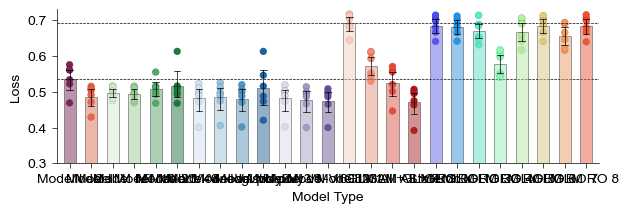

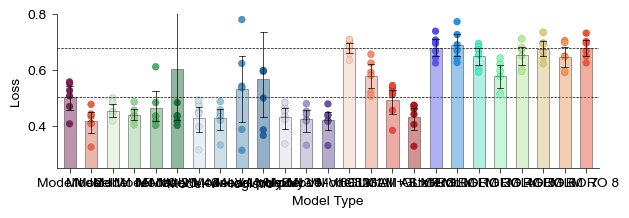

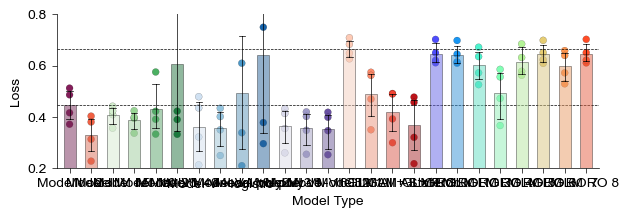

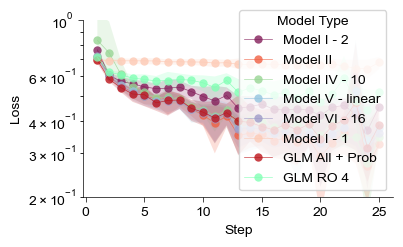

In [5]:
ModelNames = ['Model I - 2', 
                  'Model II', #'Model III',
                  'Model IV - 5', 'Model IV - 10', 'Model IV - 20', 'Model IV - 40',
                  'Model V - linear', 'Model V - logistic', 'Model V - poly2', 'Model V - poly3',
                  'Model VI - 8', 'Model VI - 16', 'Model VI - 32']

ModelNames2 = ['Model I - 1', 'GLM All'] + ['GLM All + State', 'GLM All + Prob'] + [f'GLM RO {i}' for i in [0, 1, 3, 4, 5, 6, 7, 8]]
idx = np.where(np.isin(AvgLoss['Model Type'], ModelNames+ModelNames2))[0]
Data = SubDict(AvgLoss, AvgLoss.keys(), idx)

# Statistical test
stat_names = ModelNames + ModelNames2
print(np.unique(Data['Model Type']))
for i in [6, 12, 18]:
    mat = np.zeros((len(stat_names), len(stat_names)))
    SubData = SubDict(Data, Data.keys(), np.where(Data['Step'] == i)[0])
    for j in range(len(stat_names)-1):
        for k in range(j+1, len(stat_names)):
            idx0 = np.where(SubData['Model Type'] == stat_names[j])[0]
            idx1 = np.where(SubData['Model Type'] == stat_names[k])[0]
            mat[j, k] = ttest_rel(SubData['Loss'][idx0], SubData['Loss'][idx1])[1]
            mat[k, j] = mat[j, k]
    
    D = pd.DataFrame(mat, index=stat_names, columns=stat_names)
    D.to_excel(join(figdata, code_id+f'_loss_stat_step{i}.xlsx'), index=False)

idx = np.where(np.isin(Data['Model Type'], ModelNames+ModelNames2))[0]
Data = SubDict(Data, Data.keys(), idx)

def plot_decode_error(SubData, step, ylim: tuple[float, float]):
    a = np.mean(SubData['Loss'][SubData['Model Type'] == 'Model I - 1'])
    b = np.mean(SubData['Loss'][SubData['Model Type'] == 'Model I - 2'])
    fig = plt.figure(figsize=(7, 2))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax.axhline(a, 0, 30, color='k', ls='--', linewidth=0.5)
    ax.axhline(b, 0, 30, color='k', ls='--', linewidth=0.5)
    sns.stripplot(
        x='Model Type',
        y='Loss',
        hue='Model Type',
        data=SubData,
        order=ModelNames + ModelNames2,
        hue_order=ModelNames + ModelNames2,
        palette=ModelPalette[:19]+ModelPalette[20:],
        edgecolor='black',
        linewidth=0.1,
        size=5,
        jitter=0,
        zorder=1
        #gap=0.3,
        #flierprops={'markersize': 1},
    )
    sns.barplot(
        x='Model Type',
        y='Loss',
        hue='Model Type',
        data=SubData,
        order=ModelNames + ModelNames2,
        hue_order=ModelNames + ModelNames2,
        palette=ModelPalette[:19]+ModelPalette[20:],
        edgecolor='black',
        linewidth=0.5,
        capsize=0.3,
        gap=0.3,
        alpha=0.5,
        err_kws={'linewidth': 0.5, 'color': 'k'},
        zorder=2
    )
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlim(-0.6, 24.6)
    plt.savefig(join(loc, f"step {step}.png"), dpi=600)
    plt.savefig(join(loc, f"step {step}.svg"), dpi=600)
    plt.show()
    
idx = np.where(Data['Step'] == 6)[0]
SubData = SubDict(Data, Data.keys(), idx)
plot_decode_error(SubData, 7, (0.3, 0.73))

idx = np.where(Data['Step'] == 12)[0]
SubData = SubDict(Data, Data.keys(), idx)
plot_decode_error(SubData, 13, (0.25, 0.8))

idx = np.where(Data['Step'] == 18)[0]
SubData = SubDict(Data, Data.keys(), idx)
plot_decode_error(SubData, 19, (0.2, 0.8))

ModelNames_Subset = [
    'Model I - 2', 
    'Model II', 
    'Model IV - 10', 
    'Model V - linear',
    'Model VI - 16',
    'Model I - 1',
    'GLM All + Prob',
    'GLM RO 4'
]
Color_Subset = [
    ModelPalette[0],
    ModelPalette[1],
    ModelPalette[3],
    ModelPalette[7],
    ModelPalette[11],
    ModelPalette[13], 
    ModelPalette[16],
    ModelPalette[21],
]
idx = np.where(np.isin(AvgLoss['Model Type'], ModelNames_Subset))[0]
SubData = SubDict(AvgLoss, AvgLoss.keys(), idx)
fig = plt.figure(figsize=(4, 2.3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Step',
    y='Loss',
    hue='Model Type',
    data=SubData,
    palette=Color_Subset,
    hue_order=ModelNames_Subset,
    linewidth=0.5,
    err_kws={'edgecolor': None},
    marker='o',
    markersize=6,
    alpha=0.8,
    markeredgewidth=0
)
ax.semilogy()
ax.set_ylim(0.2, 1)
plt.savefig(join(loc, "Loss with Sequence Lengths.png"), dpi=600)
plt.savefig(join(loc, "Loss with Sequence Lengths.svg"), dpi=600)
plt.show()